In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1.Augmentation을 적용한 데이터셋 만들기

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)

    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img


# 라벨 섞기
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a=None):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label


def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a=image_a))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            # cutmix(batch_size=batch_size, num_classes=num_classes),
            # lambda images, labels: tf.py_function(cutmix, [images, labels, batch_size, 224, num_classes], [tf.float32, tf.float32]),
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            # onehot(num_classes=num_classes),
            # lambda image, label: onehot(image, label, num_classes),
            num_parallel_calls=2
        )
    # if not is_test:
    #     ds = ds.repeat()
    #     ds = ds.shuffle(200)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# 데이터셋 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.B1JRIY_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.B1JRIY_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
num_classes = ds_info.features["label"].num_classes

In [ ]:
ds_train_no_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

# 2. 모델 만들기

In [ ]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# 3. 모델 훈련하기

sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용하기

In [ ]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

resnet50.compile(
    # loss='sparse_categorical_crossentropy',
    loss = 'categorical_crossentropy', # cutmix 적용을 위해 sparse 제거
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_mix = resnet50.fit(
    ds_train_no_cutmix, # cutmix 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 52s 49ms/step - loss: 0.3453 - accuracy: 0.9110 - val_loss: 1.1053 - val_accuracy: 0.6880
Epoch 2/20
750/750 [==============================] - 36s 48ms/step - loss: 0.1957 - accuracy: 0.9578 - val_loss: 1.1439 - val_accuracy: 0.6881
Epoch 3/20
750/750 [==============================] - 36s 48ms/step - loss: 0.1362 - accuracy: 0.9734 - val_loss: 1.1012 - val_accuracy: 0.6981
Epoch 4/20
750/750 [==============================] - 36s 48ms/step - loss: 0.0950 - accuracy: 0.9815 - val_loss: 1.0446 - val_accuracy: 0.7239
Epoch 5/20
750/750 [==============================] - 36s 48ms/step - loss: 0.0676 - accuracy: 0.9903 - val_loss: 1.0255 - val_accuracy: 0.7234
Epoch 6/20
750/750 [==============================] - 36s 48ms/step - loss: 0.0388 - accuracy: 0.9942 - val_loss: 1.0391 - val_accuracy: 0.7252
Epoch 7/20
750/750 [==============================] - 36s 49ms/step - loss: 0.0361 - accuracy: 0.9961 - val_loss: 1.1521 - val_accuracy:

In [ ]:
aug_resnet50.compile(
    # loss='sparse_categorical_crossentropy',
    loss = 'categorical_crossentropy', # cutmix 적용을 위해 sparse 제거
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mix = aug_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 51s 50ms/step - loss: 2.5781 - accuracy: 0.5416 - val_loss: 1.3390 - val_accuracy: 0.6308
Epoch 2/20
750/750 [==============================] - 36s 49ms/step - loss: 2.4561 - accuracy: 0.5831 - val_loss: 1.1426 - val_accuracy: 0.6803
Epoch 3/20
750/750 [==============================] - 36s 48ms/step - loss: 2.3597 - accuracy: 0.6151 - val_loss: 1.3411 - val_accuracy: 0.6321
Epoch 4/20
750/750 [==============================] - 36s 48ms/step - loss: 2.2334 - accuracy: 0.6528 - val_loss: 1.3056 - val_accuracy: 0.6461
Epoch 5/20
750/750 [==============================] - 36s 49ms/step - loss: 2.1896 - accuracy: 0.6632 - val_loss: 1.3564 - val_accuracy: 0.6294
Epoch 6/20
750/750 [==============================] - 36s 49ms/step - loss: 2.0976 - accuracy: 0.6968 - val_loss: 1.0735 - val_accuracy: 0.7053
Epoch 7/20
750/750 [==============================] - 36s 48ms/step - loss: 2.0551 - accuracy: 0.7094 - val_loss: 1.3871 - val_accuracy:

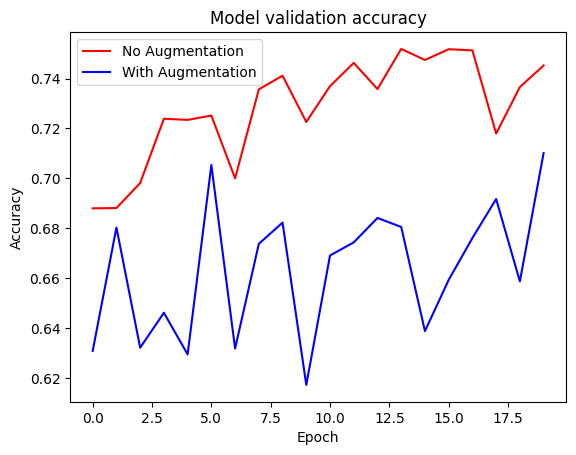

In [ ]:
plt.subplot(2, 1, 1)

plt.plot(history_resnet50_no_mix.history['val_loss'], 'r')
plt.plot(history_resnet50_mix.history['val_loss'], 'b')

plt.subplot(2, 1, 2)

plt.plot(history_resnet50_no_mix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mix.history['val_accuracy'], 'b')

plt.title('Model validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다.


plt.show()

# 5. Augmentation에 의한 모델 성능 비교

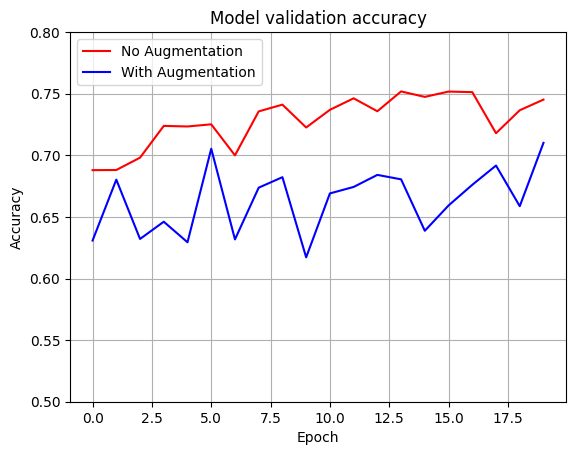

In [ ]:
plt.plot(history_resnet50_no_mix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mix.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다.
plt.show()